In [3]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

t = time.time()

# 0 - Création des fonctions utiles

In [13]:
def sentiment140(stop_words, lemmatization, negation, nb_data):
    """Fonction permettant d'ouvrir un échantillon de la base Sentiment140 préprocessée avec la combinaison 
    de booléens (stop_words, lemmatization, negation)"""

    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "Sentiment140", file + ".bz2")).sample(nb_data, random_state=1234)

In [15]:
sentiment140(False, False, False, 10)

,sentiment,id,date,query_string,user,text
599410,0,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,0,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,4,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,0,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,4,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,4,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,0,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,4,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,0,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,0,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [5]:
class Modelisation():
    """Classe permettant d'entrainer un modèle et de l'évaluer"""
    
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)
        
        if isinstance(model, MultinomialNB):
            X = X.toarray()

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

In [6]:
def comparaison(X, y, N, model, scaling=True, show_graph=True):
    """
    Création d'un DataFrame qui contient les performances des différents couples (vectorizer, model) étudiés
    Les performances regardées sont l'aire sous la courbe ROC, la précision et la "balanced accuracy"
    N correspond au nombre de features que vont utiliser les vectorizers
    """
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)
    
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

In [7]:
def influence_preprocessing(N, model, show_graph=False, show_table=False):
    """Création d'un DataFrame qui regroupe les performances des couples (vectorizer, model) sur les différents 
    "états de preprocessing" de la base Sentiment140, en fonction de la combinaison (stop_words, lemmatization, negation) """
    
    tables = []
    for stop_words in [False, True]:
        for lemmatization in [False, True]:
            for negation in [False, True]:
                print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
                df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
                X = df_temp.text.to_list()
                y = df_temp.sentiment.to_list()            
                df_metrics = comparaison(X, y, N, model, show_graph=show_graph)
                if show_table:
                    display(df_metrics)
                df_metrics['stop_words'] = stop_words
                df_metrics['lemmatization'] = lemmatization
                df_metrics['negation'] = negation
                tables.append(df_metrics)
    return pd.concat(tables)

In [8]:
def influence_features(X, y, max_features_list, model, scaling=True):
    """Comparaison des performances des couples (vectorizer, model) en faisant varier le nombre de features"""
    
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

# 1 - Sélection des meilleurs paramètres du modèle Multinomial Naive Bayes

On commence par choisir le nombre de lignes que l'on extrait de la base Sentiment140, sur laquelle on va entraîner et évaluer notre modèle.

In [8]:
NB_DATA = 50000

## 1.1 - Comparaison des méthodes de preprocessing et de "feature extraction" (vectorizer)

In [22]:
%%time
df_metrics = influence_preprocessing(2500, MultinomialNB())

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True


In [23]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 2500 ngram 2,0.7438,0.743714,0.817094,False,True,False
TfidfVectorizer 2500 ngram 2,0.7450,0.744979,0.816081,False,False,False
TfidfVectorizer 2500 ngram 2,0.7411,0.741108,0.814285,False,True,True
TfidfVectorizer 2500 ngram 2,0.7395,0.739598,0.814207,False,False,True
CountVectorizer 2500 ngram 2,0.7467,0.746595,0.810869,False,True,False
CountVectorizer 2500 ngram 2,0.7449,0.744859,0.810034,False,False,False
CountVectorizer 2500 ngram 2,0.7466,0.746546,0.809783,False,True,True
CountVectorizer 2500 ngram 2,0.7441,0.744126,0.808883,False,False,True
TfidfVectorizer 2500,0.7280,0.728192,0.789980,False,False,True
TfidfVectorizer 2500 ngram 2,0.7252,0.725204,0.787772,True,False,False


In [24]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
CountVectorizer 2500 ngram 2,0.7467,0.746595,0.810869,False,True,False
CountVectorizer 2500 ngram 2,0.7466,0.746546,0.809783,False,True,True
TfidfVectorizer 2500 ngram 2,0.7450,0.744979,0.816081,False,False,False
CountVectorizer 2500 ngram 2,0.7449,0.744859,0.810034,False,False,False
CountVectorizer 2500 ngram 2,0.7441,0.744126,0.808883,False,False,True
TfidfVectorizer 2500 ngram 2,0.7438,0.743714,0.817094,False,True,False
TfidfVectorizer 2500 ngram 2,0.7411,0.741108,0.814285,False,True,True
TfidfVectorizer 2500 ngram 2,0.7395,0.739598,0.814207,False,False,True
CountVectorizer 2500,0.7306,0.730729,0.785855,False,False,True
CountVectorizer 2500,0.7289,0.729160,0.776643,False,True,True


Pour N=500, la combinaison optimale semble être stop_words=False, lemmatization=True, negation=True

Cependant, N=500 est un nombre de features assez faible. Il convient donc de regarder les tendances qui se dégagent pour des nombres de features plus élevés.

Pour N=1000, la combinaison optimale est stop_words=False, lemmatization=True, negation=False

Pour N=2500, la combinaison optimale est à nouveau stop_words=False, lemmatization=True, negation=True

Finalement, pour la suite, nous retiendrons la combinaison stop_words=False, lemmatization=True, negation=False

Enfin, les vectorizers les plus performants semblent être les CountVectorizer et TfidfVectorizer avec ngram.

## Paramètres retenus : 

In [28]:
NB_DATA = 50000
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False

df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)
X = df.text.to_list()
y = df.sentiment.to_list()

## 1.2 - Comparaison par rapport au nombre de features

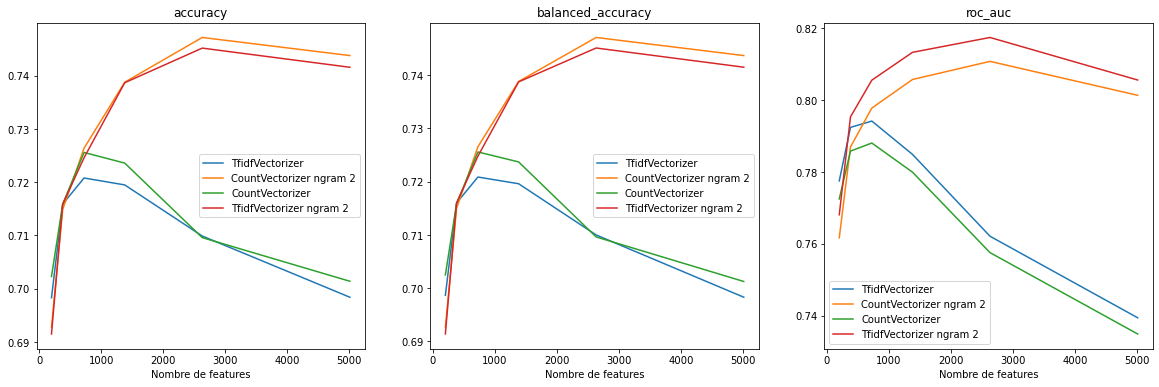

,accuracy,balanced_accuracy,roc_auc,features,method
0,0.7023,0.702503,0.772485,199,CountVectorizer
1,0.6983,0.698686,0.777516,199,TfidfVectorizer
2,0.6928,0.692687,0.761664,199,CountVectorizer ngram 2
3,0.6915,0.691411,0.768081,199,TfidfVectorizer ngram 2
4,0.7159,0.715913,0.785804,380,CountVectorizer
5,0.7159,0.716025,0.792405,380,TfidfVectorizer
6,0.7149,0.715025,0.786963,380,CountVectorizer ngram 2
7,0.7159,0.716030,0.795331,380,TfidfVectorizer ngram 2
8,0.7256,0.725590,0.788048,724,CountVectorizer
9,0.7208,0.720883,0.794165,724,TfidfVectorizer


In [27]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
influence_features(X, y, max_features_list, MultinomialNB())

A nouveau, il apparaît que les vectorizers les plus performants sont les CountVectorizer et TfidfVectorizer avec ngram. Nous ne garderons que le CountVectorizer avec ngram pour l'estimation finale.

## 1.3 - GridSearch pour obtenir les meilleurs paramètres

On utilise les paramètres choisis au vu des résultats des études précédentes.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

In [11]:
%%time
# CountVectorizer
text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
nb_max_words = len(CountVectorizer().fit(X_train).get_feature_names())

parameters = {'vect__max_features' : np.logspace(2.3, np.log10(nb_max_words), 6, endpoint=True, dtype=int),
          'vect__ngram_range' : [(1,1),(1,2)],
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring='balanced_accuracy', cv=5)
_ = grid_clf.fit(X_train, y_train)


print('Balanced Accuracy : %.3f' % grid_clf.best_estimator_.score(X_train, y_train))
print('Best Balanced Accuracy Through Grid Search : %.3f' % grid_clf.best_score_)
print('Best Parameters : ', grid_clf.best_params_)

Balanced Accuracy : 0.811
Best Balanced Accuracy Through Grid Search : 0.768
Best Parameters :  {'clf__alpha': 1, 'vect__max_features': 9880, 'vect__ngram_range': (1, 2)}


# 2 - Estimation finale du modèle

On utilise les hyperparamètres optimaux d'après le GridSearch

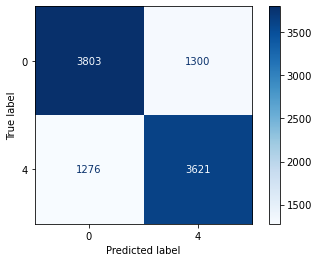

Accuracy : 0.7424
Balanced accuracy : 0.7423
ROC AUC : 0.7902


In [12]:
%%time
m = Modelisation(X, y, CountVectorizer(max_features=9880, ngram_range=(1,2)), MultinomialNB(alpha=1))
m.show_conf_matrix()

In [ ]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")